In [5]:
#install PyG in google colab
#!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
#!pip install forgi
#!tar -xf data.tar.xz

import numpy as np
import torch as th
import forgi.threedee.model.coarse_grain as ftmc
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt

from pyg_classifier.data import CGDataset


print(th.__version__)
print(th.cuda.is_available())

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print("Using:", device)



1.10.2
True
Using: cuda


TODO:
*  figure out how PyG returns graph level predictions (shape of prediction doesnt match shape of labels per batch)

In [6]:
#Model

import torch.nn.functional as F
import torch_geometric.nn as tgnn

#Coarse Grain RNA Classifier Model
class CG_Classifier(th.nn.Module):
    def __init__(self):
        self.c = 0
        super(CG_Classifier, self).__init__()
        
        self.conv1 = tgnn.TAGConv(18, 200, K=2)
        self.conv2 = tgnn.TAGConv(200, 200, K=2)
        self.conv3 = tgnn.TAGConv(200, 200, K=2)
        self.conv4 = tgnn.TAGConv(200, 200, K=2)
        self.conv5 = tgnn.TAGConv(200, 50, K=2)

        self.sage_conv1 = tgnn.SAGEConv(50, 100)
        self.sage_conv2 = tgnn.SAGEConv(100, 100)
        self.sage_conv3 = tgnn.SAGEConv(100, 100)
        self.sage_conv4 = tgnn.SAGEConv(100, 100)
        self.sage_conv5 = tgnn.SAGEConv(100, 50)
        
        self.classify = th.nn.Sequential(
            th.nn.Linear(50, 512),
            th.nn.ELU(),
            th.nn.Linear(512, 512),
            th.nn.ELU(),
            th.nn.Linear(512, 512),
            th.nn.ELU(),
            th.nn.Linear(512, 512),
            th.nn.ELU(),
            th.nn.Linear(512, 1)
        )
        
    def forward(self, data):
        x = data.x
        edge_index = data.edge_index
        batch = data.batch

        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.conv2(x, edge_index)
        x = F.elu(x)
        x = self.conv3(x, edge_index)
        x = F.elu(x)
        x = self.conv4(x, edge_index)
        x = F.elu(x)
        x = self.conv5(x, edge_index)
        x = F.elu(x)

        

        x = self.sage_conv1(x, edge_index)
        x = F.elu(x)
        x = self.sage_conv2(x, edge_index)
        x = F.elu(x)
        x = self.sage_conv3(x, edge_index)
        x = F.elu(x)
        x = self.sage_conv4(x, edge_index)
        x = F.elu(x)
        x = self.sage_conv5(x, edge_index)
        x = F.elu(x)

        x = tgnn.global_mean_pool(x, batch) #self.readout(x, edge_index)
        
        return self.classify(x)

In [7]:
#Training Set


training_dir = "./data/train_set"
rmsd_list = "./data/truncated_train_rmsd.txt"

training_dataset = CGDataset(training_dir, rmsd_list)


In [8]:
#Validation Set
val_dir = "./data/val_set"
val_rmsd = "./data/val_rmsd_list.txt"

val_dataset = CGDataset(val_dir, val_rmsd)


In [7]:
print(training_dataset)
print(training_dataset[0])
print(training_dataset.data.x.shape)
print(training_dataset.data.is_undirected())
print(len(training_dataset))
print(training_dataset[0].num_nodes)
print(training_dataset[0].y)
print(training_dataset[0].num_edges)

CGDataset(760)
Data(x=[12, 18], edge_index=[2, 24], y=[1])
torch.Size([11769, 18])
True
760
12
tensor([6.5820])
24


In [9]:
#Training
import time
start = time.perf_counter()

#device = th.device('cuda' if th.cuda.is_available() else 'cpu')
model = CG_Classifier().to(device)

b_size = 64
train_dataloader = DataLoader(training_dataset, batch_size=b_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=b_size)

opt = th.optim.Adam(model.parameters(), lr=1e-3)
scheduler = th.optim.lr_scheduler.CosineAnnealingWarmRestarts(opt, T_0=500)#, T_mult=2)
model.train()

epochs = 1000

#training setup
epoch_losses = []
val_losses = []
learning_rates = []
for epoch in range(epochs):
    epoch_loss = 0
    learning_rates.append(scheduler.get_last_lr()[0])
    for iter, data in enumerate(train_dataloader):
        data = data.to(device)
        opt.zero_grad()
        pred = model(data)
        loss = F.smooth_l1_loss(th.reshape(pred, (-1,)), data.y, reduction='mean')
        loss.backward()
        opt.step()
        epoch_loss += loss.detach().item()

    #apply lr changes according to scheme
    scheduler.step()

    epoch_loss /= (iter + 1)
    epoch_losses.append(epoch_loss)

    #val setup
    val_loss = 0
    for i, v_data in enumerate(val_dataloader):
        v_data = v_data.to(device)
        val_pred = model(v_data)
        v_loss = F.smooth_l1_loss(th.reshape(val_pred, (-1,)), v_data.y, reduction='mean')
        val_loss += v_loss.detach().item()

    val_loss /= (i + 1)
    
    val_losses.append(val_loss)
    
    
    th.save(model.state_dict(), "pyg_model_data/model_epoch" + str(epoch) + ".pth")
    
    if epoch % 5 == 0:
        print("Epoch {}: Training loss {:.4f}, Validation loss {:.4f}, learning rate: {:.5f}".format(epoch, epoch_loss, val_loss, scheduler.get_last_lr()[0]))
        
end = time.perf_counter()

print("Training took {:.2f} hours".format((end - start)/60/60))
print("Minimum Training Loss {:.4f} in epoch {}".format(min(epoch_losses), epoch_losses.index(min(epoch_losses))))
print("Minimum Validation Loss {:.4f} in epoch {}".format(min(val_losses), val_losses.index(min(val_losses))))

#plot the training run
plt.plot(epoch_losses)
plt.plot(val_losses, 'r')
plt.title("Training Loss")
plt.ylim(ymax=20, ymin=0)
plt.draw()

Epoch 0: Training loss 10.9402, Validation loss 14.2802, learning rate: 0.00100
Epoch 5: Training loss 4.7997, Validation loss 16.9738, learning rate: 0.00100


KeyboardInterrupt: 

In [63]:
#store training run data

file = "pyg_loss_data_2022-02-17.txt"

with open("data/" + file, "w") as fh:
    fh.write(str(epoch_losses) + "\n")
    fh.write(str(val_losses) + "\n")
    fh.write(str(learning_rates))

In [ ]:
#get training run data

file = "pyg_loss_data_2022-02-15.txt"

file_lines = []
with open("data/" + file, "r") as fh:
    for line in fh.readlines():
        file_lines.append(line.rstrip("]\n").lstrip("[").split(","))

epoch_losses = [float(a) for a in file_lines[0]]
val_losses = [float(b) for b in file_lines[1]]
learning_rates = [float(c) for c in file_lines[2]]

print("Minimum Training Loss {:.4f} in epoch {}".format(min(epoch_losses), epoch_losses.index(min(epoch_losses))))
print("Minimum Validation Loss {:.4f} in epoch {}".format(min(val_losses), val_losses.index(min(val_losses))))


Minimum Training Loss 0.0002 in epoch 999
Minimum Validation Loss 13.1550 in epoch 607


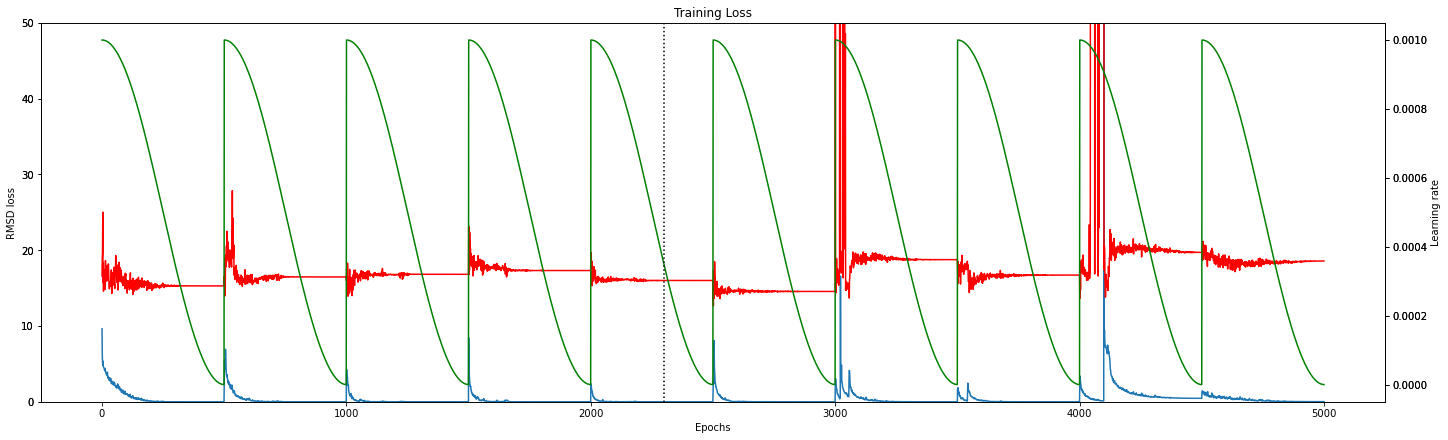

In [59]:
#plot the training run
fig, ax1 = plt.subplots(layout='constrained', figsize=(20, 6))
ax1.secondary_yaxis('left')
ax1.plot(epoch_losses)
ax1.plot(val_losses, 'r')
ax2 = ax1.twinx()
ax2.secondary_yaxis('right')
ax2.plot(learning_rates, 'g')
plt.title("Training Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("RMSD loss")
ax2.set_ylabel("Learning rate")
ax1.set_ybound(lower=0, upper=50)
plt.axvline(x = 2300, c = 'black', ls = ':')
#plt.axvline(x = 96, c = 'black', ls = ':')
#plt.axvline(x = 145, c = 'black', ls = ':')
#plt.axvline(x = 190, c = 'black', ls = ':')
#plt.axvline(x = 250, c = 'black', ls = ':')
#plt.axvline(x = 321, c = 'black', ls = ':')
#plt.axvline(x = 404, c = 'black', ls = ':')
plt.draw()

In [24]:
#Test Data
test_dir = "./data/test_set"
test_rmsd = "./data/test_rmsd_list.txt"

test_dataset = CGDataset(test_dir, test_rmsd)

test_dataloader = DataLoader(test_dataset)

In [25]:
#5S rRNA and tRNA Test Data (previous training data)
st_test_dir = "./data/old_training_set"
st_test_rmsd = "./data/old_train_rmsd_list.txt"

st_test_dataset = CGDataset(st_test_dir, st_test_rmsd)

st_test_dataloader = DataLoader(st_test_dataset)

Normal Test Set
tensor([28.3790], device='cuda:0') tensor([[28.4765]], device='cuda:0', grad_fn=<AddmmBackward0>) 0.0974578857421875
tensor([0.], device='cuda:0') tensor([[39.8427]], device='cuda:0', grad_fn=<AddmmBackward0>) 39.84265899658203
Mean Test loss: 	 13.4962
Std. Dev. of Test loss:  10.3870
Min loss: 		 0.0975
First Quantile: 	 4.4275
Median: 		 11.2377
Third Quantile: 	 22.3027
Max Loss: 		 39.8427


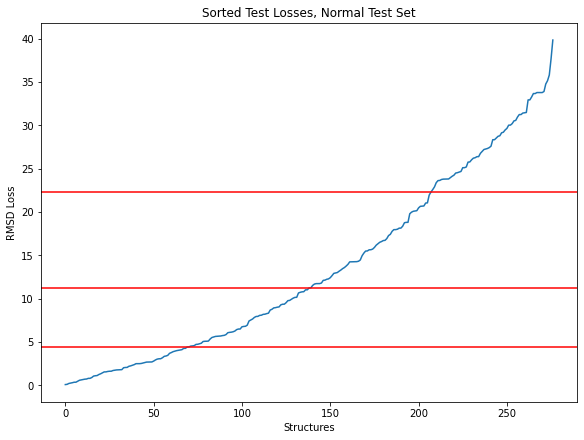

5S rRNA and tRNA Test Set
tensor([13.4690], device='cuda:0') tensor([[13.4686]], device='cuda:0', grad_fn=<AddmmBackward0>) 0.0003871917724609375
tensor([0.], device='cuda:0') tensor([[51.1184]], device='cuda:0', grad_fn=<AddmmBackward0>) 51.118438720703125
Mean Test loss: 	 6.1677
Std. Dev. of Test loss:  7.6024
Min loss: 		 0.0004
First Quantile: 	 1.6270
Median: 		 3.4823
Third Quantile: 	 6.7526
Max Loss: 		 51.1184


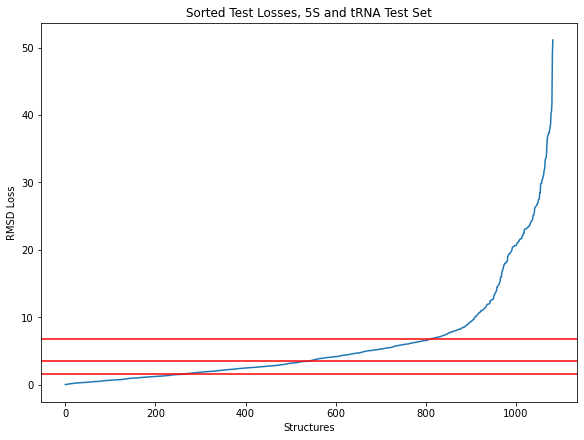

In [62]:
#Test
import math

if "model" not in globals():
    model = CG_Classifier(num_features=3)

model.to(device)

model.load_state_dict(th.load("pyg_model_data/model_epoch2501.pth"))

model.eval()

for loader in [test_dataloader, st_test_dataloader]:
    max_label = 0
    max_loss = 0
    max_pred = 0
    min_label = math.inf
    min_loss = math.inf
    min_pred = math.inf
    test_losses = []
    for test_graph in loader:
        test_graph = test_graph.to(device)
        test_pred = model(test_graph)
        test_loss = F.l1_loss(th.reshape(test_pred, (-1,)), test_graph.y).item() #smooth_l1_loss
        test_losses.append(test_loss)
        if test_loss > max_loss:
            max_loss = test_loss
            max_label = test_graph.y
            max_pred = test_pred
        if test_loss < min_loss:
            min_loss = test_loss
            min_label = test_graph.y
            min_pred = test_pred
        if test_pred < 0:
            print(test_graph.y, test_pred)

    if loader == test_dataloader:
        print("Normal Test Set")
    elif loader == st_test_dataloader:
        print("5S rRNA and tRNA Test Set")
    print(min_label, min_pred, min_loss)
    print(max_label, max_pred, max_loss)
    test_mean = np.mean(test_losses)
    test_std = np.std(test_losses)
    test_fq = np.quantile(test_losses, q = 0.25)
    test_median = np.median(test_losses)
    test_tq = np.quantile(test_losses, q = 0.75)
    print("Mean Test loss: \t {:.4f}".format(test_mean))
    print("Std. Dev. of Test loss:  {:.4f}".format(test_std))
    print("Min loss: \t\t {:.4f}".format(min(test_losses)))
    print("First Quantile: \t {:.4f}".format(test_fq))
    print("Median: \t\t {:.4f}".format(test_median))
    print("Third Quantile: \t {:.4f}".format(test_tq))
    print("Max Loss: \t\t {:.4f}".format(max(test_losses)))

    #print(sorted(test_losses)[-5:])

    fig, axs = plt.subplots(layout='constrained', figsize=(8, 6))
    axs.plot(sorted(test_losses))
    #plt.title("Sorted Test Losses")
    if loader == test_dataloader:
        plt.title("Sorted Test Losses, Normal Test Set")
    elif loader == st_test_dataloader:
        plt.title("Sorted Test Losses, 5S and tRNA Test Set")
    plt.ylabel("RMSD Loss")
    plt.xlabel("Structures")
    plt.axhline(y = test_fq, color = 'r')
    plt.axhline(y = test_median, color = 'r')
    plt.axhline(y = test_tq, color = 'r')
    plt.show()